/Users/vlzqz/Desktop/escuela/spring 2025/440 social networks/Classmf/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


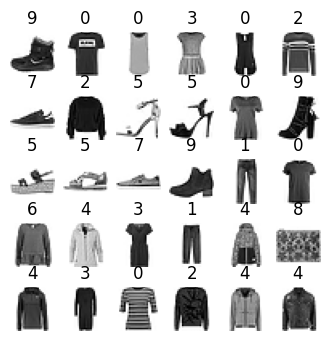

In [1]:
import matplotlib as mpl
from datasets import load_dataset

from genaibook.core import show_images

mpl.rcParams["image.cmap"] = "gray_r"


fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:30]
classes = fashion_mnist["train"]["label"][:30]
show_images(clothes, titles=classes, figsize=(4, 4))

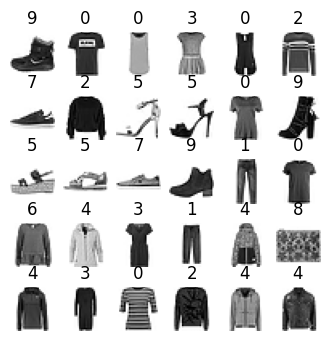

In [2]:
import matplotlib as mpl
from datasets import load_dataset

from genaibook.core import show_images

#mpl.rcParams["image.cmap"] = "gray_r"


fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:30]
classes = fashion_mnist["train"]["label"][:30]
show_images(clothes, titles=classes, figsize=(4, 4))

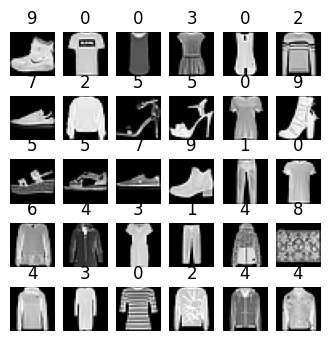

In [3]:
import matplotlib as mpl
from datasets import load_dataset

from genaibook.core import show_images

mpl.rcParams["image.cmap"] = "gray"


fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:30]
classes = fashion_mnist["train"]["label"][:30]
show_images(clothes, titles=classes, figsize=(4, 4))

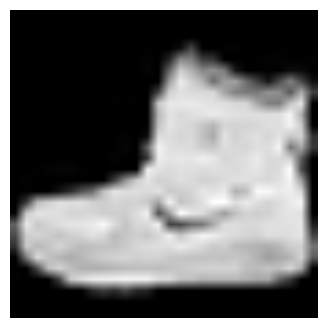

In [4]:
import cv2
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset
fashion_mnist = load_dataset("fashion_mnist")
image = fashion_mnist["train"]["image"][0]  # Get one image

# Convert PIL image to a NumPy array
image_np = np.array(image)

# Set desired figure size (width, height) in inches
figsize = (4, 4)

# Calculate new dimensions based on figsize and DPI
dpi = 100  # Dots per inch (adjust if necessary)
new_width = int(figsize[0] * dpi)
new_height = int(figsize[1] * dpi)

# Resize the image
resized_image = cv2.resize(image_np, (new_width, new_height))

# Display using matplotlib instead of cv2_imshow
plt.figure(figsize=figsize)
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
import torch
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Pad(2),  # Add 2 pixels on all sides
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}


train_dataset = fashion_mnist["train"].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

In [6]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10,  # Enable class conditioning
)

/Users/vlzqz/Desktop/escuela/spring 2025/440 social networks/Classmf/.venv/lib/python3.13/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [7]:
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

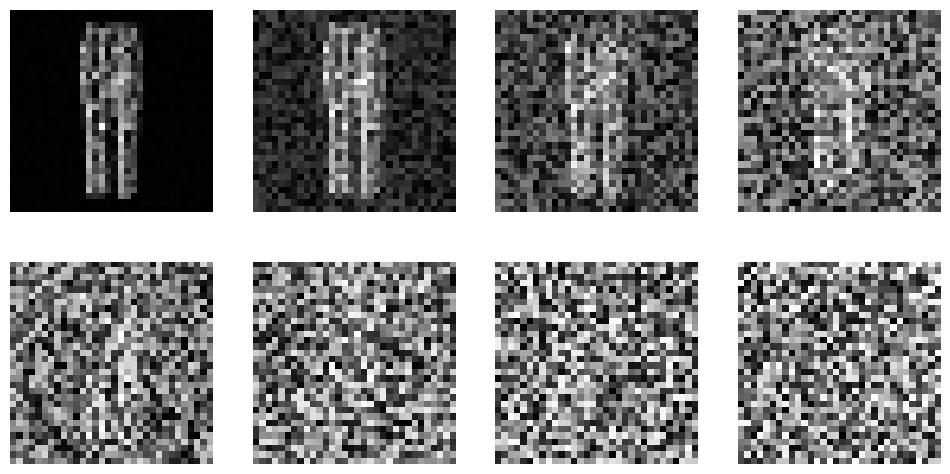

In [8]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [9]:
from torch.nn import functional as F
from tqdm import tqdm
import torch.backends.mps as mps
from genaibook.core import get_device

# Initialize the scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

# Check if MPS (Metal Performance Shaders) is available for M2
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = get_device()
    print(f"Using {device}")

# Optimize model parameters
num_epochs = 10
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []  # To store loss values for plotting

# Move model to appropriate device
model = model.to(device)

# Optional: Set smaller batch size if memory is an issue
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Enable mixed precision for faster training (if supported)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Train the model with optimizations
for epoch in (progress := tqdm(range(num_epochs))):
    epoch_loss = 0.0
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader),
        )
    ):
        # Load the input images and classes
        clean_images = batch["images"].to(device)
        class_labels = batch["labels"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Use automatic mixed precision where supported
        with torch.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            # Get the model prediction for the noise
            noise_pred = model(
                noisy_images,
                timesteps,
                class_labels=class_labels,
                return_dict=False,
            )[0]

            # Compare the prediction with the actual noise
            loss = F.mse_loss(noise_pred, noise)
        
        # Update loss display
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        
        # Store the loss for later plotting
        losses.append(loss.item())
        epoch_loss += loss.item()

        # Backward pass and optimization with mixed precision where supported
        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        optimizer.zero_grad()
    
    # Print epoch summary
    avg_loss = epoch_loss / len(train_dataloader)
    progress.set_postfix(avg_loss=f"{avg_loss:.3f}")
    
    # Optional: Save checkpoint after each epoch
    # torch.save(model.state_dict(), f"diffusion_model_epoch_{epoch}.pt")

/var/folders/ln/13_rf5392kz5pchj7wyd2nhm0000gn/T/ipykernel_30053/1570812859.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


Using MPS (Apple Silicon GPU)


 10%|█         | 1/10 [15:47<2:22:05, 947.29s/it, avg_loss=0.090]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model prediction
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

In [ ]:
images = generate_from_class(0)
show_images(images, nrows=2)

In [ ]:
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
images = generate_from_class(9)
show_images(images, nrows=2)